In [1]:
# ===============================
# Cell 1: Imports
# ===============================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# ===============================
# Cell 2: Load paths and labels
# ===============================
import os
from glob import glob

data_dir = "./dataset"   # <-- change this to your dataset folder
classes = ["normal", "osteoporosis"]

all_image_paths = []
all_labels = []
for idx, cls in enumerate(classes):
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([idx]*len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_image_paths))

Total images: 372


In [5]:
# ===============================
# Cell 3: Split data
# ===============================
from sklearn.model_selection import train_test_split

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, stratify=all_labels, test_size=0.3, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, stratify=temp_labels, test_size=0.5, random_state=42
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Train: 260, Val: 56, Test: 56


In [ ]:
# ===============================
# Cell 4: Preprocessing function (Pipeline 1 - Raw Images)
# ===============================
IMG_SIZE = (224, 224)

def preprocess_image_pipeline1(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)      # read grayscale
    img = tf.image.resize(img, IMG_SIZE)          # resize
    img = tf.image.grayscale_to_rgb(img)          # (224,224,1) -> (224,224,3)
    # ❌ No normalization here
    return img, label

def make_dataset_pipeline1(paths, labels, batch_size=16, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess_image_pipeline1, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset_pipeline1(train_paths, train_labels)
val_ds = make_dataset_pipeline1(val_paths, val_labels, shuffle=False)
test_ds = make_dataset_pipeline1(test_paths, test_labels, shuffle=False)


In [6]:
# ===============================
# Cell 4: Preprocessing function
# ===============================
IMG_SIZE = (224, 224)

def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)             # read as grayscale
    img = tf.image.resize(img, IMG_SIZE)                 # resize
    img = tf.image.grayscale_to_rgb(img)                 # convert 1 -> 3 channels
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)  # normalize for pretrained
    return img, label

def make_dataset(paths, labels, batch_size=16, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels)
val_ds = make_dataset(val_paths, val_labels, shuffle=False)
test_ds = make_dataset(test_paths, test_labels, shuffle=False)

In [7]:
# ===============================
# Cell 5: Define model
# ===============================
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model.trainable = False   # freeze base layers for now

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")  # binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# ===============================
# Cell 6: Train model
# ===============================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 563ms/step - accuracy: 0.5269 - loss: 0.8116 - val_accuracy: 0.6607 - val_loss: 0.6255
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.5577 - loss: 0.7437 - val_accuracy: 0.7143 - val_loss: 0.5950
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.5423 - loss: 0.7362 - val_accuracy: 0.6786 - val_loss: 0.5842
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.5923 - loss: 0.7186 - val_accuracy: 0.6964 - val_loss: 0.5695
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.6269 - loss: 0.6741 - val_accuracy: 0.6964 - val_loss: 0.5550
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 501ms/step - accuracy: 0.6269 - loss: 0.6673 - val_accuracy: 0.6964 - val_loss: 0.5442
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - accuracy: 0.6385 - loss: 0.6333 - val_accuracy: 0.7143 - val_loss: 0.5388
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.6038 - loss: 0.6752 - val_accura

In [9]:
# ===============================
# Cell 7: Evaluation helper
# ===============================
def evaluate_and_report(model, dataset, split_name="Validation"):
    y_true = []
    y_pred = []
    for imgs, lbls in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(lbls.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())

    print(f"\n{split_name} -> Accuracy:",
          np.mean(np.array(y_true) == np.array(y_pred)))
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



Validation -> Accuracy: 0.7321428571428571
              precision    recall  f1-score   support

      normal       0.76      0.68      0.72        28
osteoporosis       0.71      0.79      0.75        28

    accuracy                           0.73        56
   macro avg       0.73      0.73      0.73        56
weighted avg       0.73      0.73      0.73        56



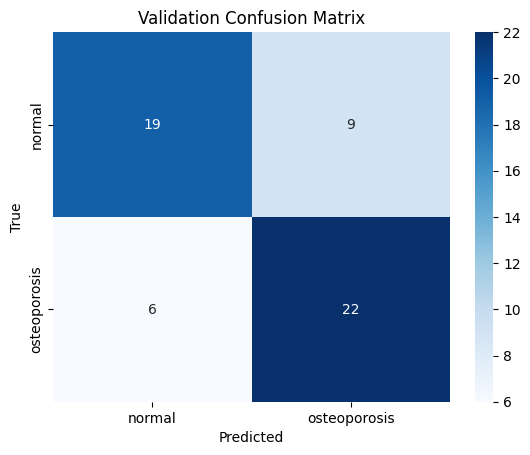


Test -> Accuracy: 0.7857142857142857
              precision    recall  f1-score   support

      normal       0.83      0.71      0.77        28
osteoporosis       0.75      0.86      0.80        28

    accuracy                           0.79        56
   macro avg       0.79      0.79      0.78        56
weighted avg       0.79      0.79      0.78        56



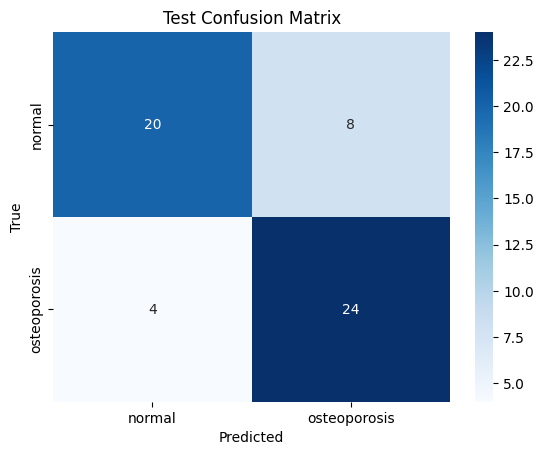

In [10]:
# ===============================
# Cell 8: Evaluate on val & test
# ===============================
evaluate_and_report(model, val_ds, split_name="Validation")
evaluate_and_report(model, test_ds, split_name="Test")